<br>
<img src="https://i.ibb.co/Lty5dh7/grover-Logo.png" width="140" height="50" align="left"><br>
<br>
<br>

# <font color=black><center>Take-home Assignment</center>
**Data Source:** https://rebrickable.com/downloads/<br>
**Contact Person:** sent by ina@grover.com on 21th April 2021, 09:00 <br>

**Data Prepration:**<br>
0-A: Extracting data from AWS db [Jump to Answer](#0-A)<br>
0-B: Profiling, Exploratory Analysis, Cleansing (T) [Jump to Answer](#0-B)<br>
0-C: Loading data into BigQuery/ Data warehousing (T) [Jump to Answer](#0-C)<br>    
    
**Question1:** (I interpret and transform your first question as follows. I hope that's what you wanted)<br> 
Prepare 3 tables and graphs under the following conditions with each making up at least 4 tables:<br>
1-A: Table with sets.year [Jump to Answer](#1-A)<br>
2-B: Table with a hierachy at themes table [Jump to Answer](#1-B)<br>
1-C: User-defined table [Jump to Answer](#1-C)<br>
<br>
**Question2:**<br>
Assume you need your dashboards from the first question to be updated automatically (on a daily basis vs real time). Please propose the design of the ETL process and the exact steps, tools, and expected implementation timeline.
[Jump to Answer](#2)<br>
    
**Question3:**<br>
Please describe the concept of Database Entity.Please suggest 3 core entities for Grover Business Model and show some examples of their properties. Illustrate these examples with operational KPIs and briefly describe why those are important as well as shown in the formulas for the underlying calculation.
[Jump to Answer](#3)<br>

In [129]:
# Reading necessary libraries
import pandas as pd												# data manipulation
import matplotlib.pyplot as plt									# graphs
import seaborn as sns											# graphs
import numpy as np												# graphs
from matplotlib import cm										# graphs
from matplotlib.pyplot import figure							# graphs
import sys														# system functions
import warnings													# indicating warnings
warnings.filterwarnings('ignore')								# ignore by default
from matplotlib.ticker import LinearLocator						# graphs
pd.set_option('display.max_columns', None)						# show all columns
pd.set_option('display.max_rows', None)							# show all rows
np.set_printoptions(threshold=sys.maxsize)						# show arrays full
pd.set_option("display.max_colwidth", -1)						# show a complete text in a cell
pd.set_option('display.float_format', lambda x: '%.2f' % x)		# precision decimals pd
np.set_printoptions(precision=3)								# precision decimals np
from xlsxwriter.workbook import Workbook						# CSV writing
import csv														# CSV writing
import pymysql													# MySql connection
import psycopg2													# PostgreSQL database adapter
import datetime													# time conversions
import random													# randomchoice
import math as math												# maths
import glob														# paths and files management
import matplotlib.image as mpimg								# matplot image
import pandasql as ps											# connect to Pandas' SQLite
import cufflinks as cf											# Cufflink
from google.cloud import bigquery								# upload to BigQuery
import google.datalab.bigquery as bq							# Pandas to BigQuery

<a id='0-A'></a>
### <font color=blue><center>0-A: Extracting data from AWS db (E)</center> ###
I uploaded the 12 CSV Lego files in my AWS account to make the prject more intresting.<br>
First, i will download the data to start the project <br>
<br>
***Note that***; the purpose of loading and unloading data from different sources or validating data is not to make analysis complicated and unappealing, but to show my standard approach of treating a large dataset.

In [201]:
# Opening a connection 
conn_info = {"host": "database-1.ccosz5b5stit.us-east-1.rds.amazonaws.com", "port": 3306, "user": "admin","password": "xxx"
             ,"database": "grover", "client_flag": CLIENT.MULTI_STATEMENTS,}
cnxn = pymysql.connect(**conn_info)

# connecting to the cursor
crsr = cnxn.cursor()

# Specifying the query / Query description:
# The idea is to generate 12 tables of this project fully automated when each time the cursor gets executed 
# Function 'PREPARE' make the variable '@s' ready by concatinating a query inside of it. The inside query gets its data from
# schema, then by the means of ROW_NUMBER and @rn, each time this query executes, @s gets a new row.
sql="""\
SET @rn = 0;
SET @s = CONCAT('SELECT * FROM ', (
	WITH table_rn AS(
		SELECT table_name, ROW_NUMBER() OVER(ORDER BY table_name) rnk, @rn
		FROM information_schema.TABLES, (SELECT @rn = 0) a, (SELECT @rn := @rn + 1 ) b
		WHERE table_schema = 'grover'
	)
	SELECT table_name
	FROM table_rn
	WHERE rnk = @rn)
 ); 
PREPARE stmt1 FROM @s; 
EXECUTE stmt1; 
DEALLOCATE PREPARE stmt1; 
"""

# table_names saves all 12 tables for 'for-loop' and creating correspondant CSVs
total_tables="SHOW TABLES"
cursor.execute(total_tables)
item=cursor.fetchall()
table_names = [i[0] for i in item]

# iterate the main query
for table_names in table_names:
    crsr.execute(sql)
    # 4 times = 4 separate sql statements (the abobe sql = (...)) to execute
    num_tries = 4
    # in case, it doesn't return anything after some attempts, it'll throw an error
    result = None
    # This iterates the 4 number of attempts to execute each statement separately
    for i in range(num_tries):
        result = crsr.fetchall()
        if result:
            break
        crsr.nextset()
    
    if not result:
        print(f"(no result found after {num_tries} attempts)")
    # Writing crsr in column_names and then open a relevant CSV file with the same name, and finally save it
    else:
        column_names = [i[0] for i in crsr.description]
        fp = open(table_names, 'w')
        myFile = csv.writer(fp, lineterminator = '\n')
        myFile.writerow(column_names)   
        myFile.writerows(rows)
        fp.close()
        # If everything goes well, show me the result
        print('Table', table_names, 'has been downloaded and generated successfully.')

Table colors has been downloaded and generated successfully.
Table elements has been downloaded and generated successfully.
Table inventories has been downloaded and generated successfully.
Table inventory_minifigs has been downloaded and generated successfully.
Table inventory_parts has been downloaded and generated successfully.
Table inventory_sets has been downloaded and generated successfully.
Table minifigs has been downloaded and generated successfully.
Table part_categories has been downloaded and generated successfully.
Table part_relationships has been downloaded and generated successfully.
Table parts has been downloaded and generated successfully.
Table sets has been downloaded and generated successfully.
Table themes has been downloaded and generated successfully.


<a id='0-B'></a>
### <font color=blue><center>0-B: Profiling, Exploratory Analysis, Cleansing (T)</center> ###
Even though the data is quite clean and ready to analyse, in order to show a sample of my work as well more or less answer your second question, I will perform transforming the data as follows.<br>


In [2]:
# Reading all the files from the project folder, alternative: using glob library
colors = pd.read_csv('colors.csv')
elements = pd.read_csv('elements.csv')
inventories = pd.read_csv('inventories.csv')
inventory_minifigs = pd.read_csv('inventory_minifigs.csv')
inventory_parts = pd.read_csv('inventory_parts.csv')
inventory_sets = pd.read_csv('inventory_sets.csv')
minifigs = pd.read_csv('minifigs.csv')
part_categories = pd.read_csv('part_categories.csv')
part_relationships = pd.read_csv('part_relationships.csv')
parts = pd.read_csv('parts.csv')
sets = pd.read_csv('sets.csv')
themes = pd.read_csv('themes.csv')

**Metadata:**<br>
<img src="https://rebrickable.com/static/img/diagrams/downloads_schema_v3.png" width="1000" height="1000" align="left"><br>
<br>


In [331]:
# Show null values and duplicates in all columns. It uses isnull function for finding nulls and duplicated function for dups.
def nulldup(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = round((df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100, 3)
    missing_data = pd.concat([total, percent], axis=1, keys=['NullTotal', 'Null%'])
    for dup in missing_data.index:
        missing_data.at[dup,'DupTotal'] = df.duplicated(subset=[dup]).sum()
        missing_data.at[dup,'Dup%'] = round((df.duplicated(subset=[dup]).sum())/df.shape[0]*100,3)
    display(missing_data)
nulldup(inventory_parts)

,NullTotal,Null%,DupTotal,Dup%
is_spare,0,0.00,903295.00,100.00
quantity,0,0.00,902975.00,99.96
color_id,0,0.00,903123.00,99.98
part_num,0,0.00,864587.00,95.72
inventory_id,0,0.00,876910.00,97.08


In [105]:
# Count Values to see what we have in each column.It's a simple count_values along with a 'for' iteration.
def count(df):
    pd.set_option('display.max_rows', 10)
    for column in df.columns:
        print(column,':')
        display(df[column].value_counts(dropna=False))
        print('___________________________________','\n')
count(inventory_parts)

inventory_id :


42856    1554
94873    1309
85198    1309
73052    1126
19403    1022
         ... 
85573    1   
24240    1   
5483     1   
21       1   
84751    1   
Name: inventory_id, Length: 26387, dtype: int64

___________________________________ 

part_num :


6141            24416
3023            16463
3024            11768
54200           11680
3004            11558
                ...  
95201pr0004     1    
11344pr0010     1    
970c00pr9964    1    
29050pr0007     1    
004231          1    
Name: part_num, Length: 38710, dtype: int64

___________________________________ 

color_id :


0       164966
15      101511
71      93417 
4       72669 
72      70546 
        ...   
1012    1     
1027    1     
1016    1     
1035    1     
1024    1     
Name: color_id, Length: 174, dtype: int64

___________________________________ 

quantity :


1      391349
2      241507
4      93239 
3      47603 
6      30075 
       ...   
129    1     
134    1     
138    1     
145    1     
511    1     
Name: quantity, Length: 322, dtype: int64

___________________________________ 

is_spare :


f    850485
t    52812 
Name: is_spare, dtype: int64

___________________________________ 



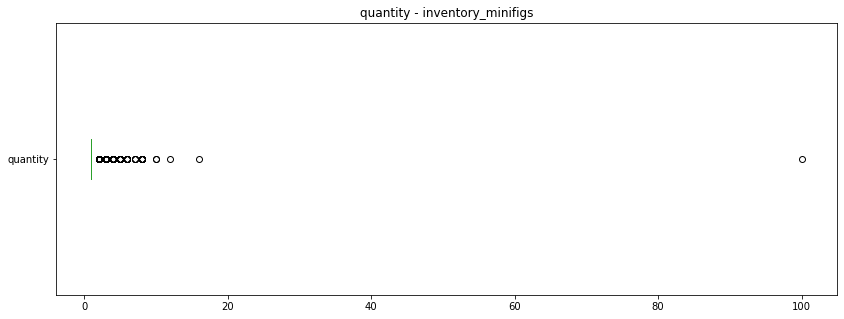

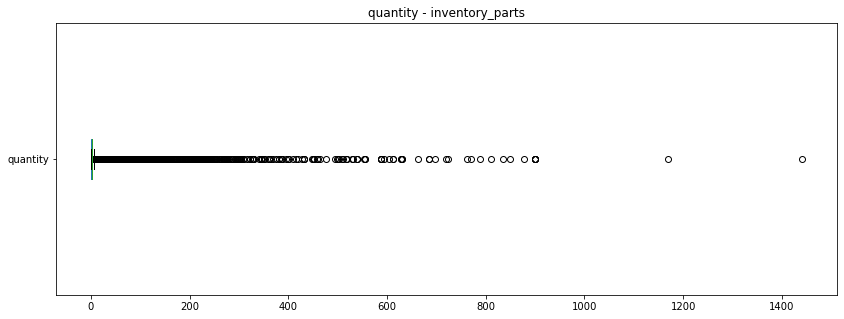

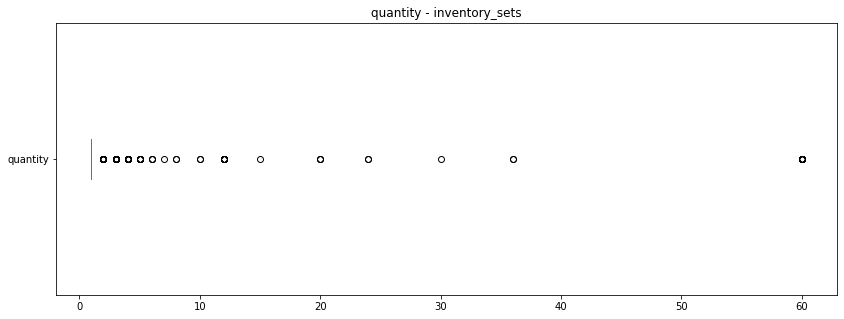

In [325]:
# Finding outliers using boxplot.

inventory_minifigs['quantity'].plot(kind='box', vert=False, figsize=(14,5));
plt.title('quantity - inventory_minifigs')
plt.show()

inventory_parts['quantity'].plot(kind='box', vert=False, figsize=(14,5));
plt.title('quantity - inventory_parts')
plt.show()

inventory_sets['quantity'].plot(kind='box', vert=False, figsize=(14,5));
plt.title('quantity - inventory_sets')
plt.show()

# We do have some outliers, particularly in minifigs dataset. But, for the time being I will not take action on that.

In [10]:
                    #///////////////////////////////////////////////////////////////////////#
                    #////                        All datasetes                          ////#
                    #///////////////////////////////////////////////////////////////////////#
# 1- Duplicates:
# It's not possible for the same product with the same version to generate a new id in 'inventories'
if inventories.duplicated(subset=['set_num','version']).sum() > 0:
    inventories.drop_duplicates(subset=['set_num','version'], keep='first')

# 2- Null Values:
# Like other datasets when there is no data (for example code color) we might replace it with -1, though not necessary
themes['parent_id'] = themes['parent_id'].fillna(-1)

<a id='0-C'></a>
### <font color=blue><center>0-C: Loading data into BigQuery/ Data warehousing (T)</center> ###
Now, the data is ready so I'll save the cleaned tables directly from Jupyter to BigQuery and then take some actions in my GCP account if needs be. <br>


In [134]:
# Credential: $env:GOOGLE_APPLICATION_CREDENTIALS="C:\Users\milad\Desktop\Data Science\Demo Projects\21- Grover\clark-643191304-9a9d84679ccd.json"

# Create file_path containing all the CSVs to write in BigQuery
file_path = ['colors.csv', 'elements.csv', 'inventories.csv', 'inventory_minifigs.csv', 'inventory_parts.csv',\
             'inventory_sets.csv', 'minifigs.csv', 'part_categories.csv', 'part_relationships.csv', 'parts.csv',\
            'sets.csv', 'themes.csv']

# for-loop to write all the files
for my_file in file_path:
    
    # define a BigQuery dataset    
    bigquery_dataset_name = ('clark-643191304', 'milad_db')
    dataset = bq.Dataset(name = bigquery_dataset_name)

    # define a BigQuery table    
    bigquery_table_name = ('clark-643191304', 'milad_db', my_file)
    table = bq.Table(bigquery_table_name)

    # Create or overwrite the existing table if it exists
    table_schema = bq.Schema.from_data(dataFrame_name)
    table.create(schema = table_schema, overwrite = True)

    # Write the DataFrame to a BigQuery table
    table.insert(dataFrame_name)

<a id='1-A'></a>
### <font color=blue><center>1-A: Table with sets.year</center> ###

In [74]:
# It will generate total number of parts produced based on the year which Lego sets were first released as long as the material
# was not 'metal.' To make it more intresting, I consider 'not made by metal' as child-friendly Lego Parts.
# Description: the main SELECT finds a relation (EXISTS) between set_num of current SELECT and set_num of CTE. 
query_q1 = """

CREATE TABLE `clark-643191304.milad_db.query_q1` AS
WITH base_table AS (
	SELECT i.set_num, p.part_material
    FROM `clark-643191304.milad_db.inventories` i, `clark-643191304.milad_db.inventory_parts` ip, `clark-643191304.milad_db.parts` p
    WHERE i.id = ip.inventory_id AND ip.part_num = p.part_num
)
SELECT s1.year year_sets_released, COUNT(s1.year) child_friendly_Lego_parts
FROM `clark-643191304.milad_db.sets` s1
WHERE EXISTS (
	SELECT *
    FROM base_table b
    WHERE s1.set_num = b.set_num AND b.part_material NOT IN ('Metal')
)
GROUP BY 1
ORDER BY 2 DESC
;

"""
dfresult1 = pd.read_gbq(query_q1, project_id='clark-643191304', dialect='standard')
dfresult1

Downloading: 100%|███████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 96.64rows/s]


,year_sets_released,child_friendly_Lego_parts
0,2020,695
1,2016,687
2,2019,673
3,2018,669
4,2015,653
5,2017,653
6,2014,551
7,2013,521
8,2012,514
9,2002,456


In [83]:
# Let's draw the graph:
# Please install 'Cufflinks' lib (pip install cufflinks) in case you cannot see this beautiful graph. 
# Interactive timeseries: Child-friendly Lego parts by released year 

# Convert int to date time year
dfresult1['year_sets_released'] = pd.to_datetime(dfresult1['year_sets_released'], format='%Y')

# Library Configuration
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
  
# to get the connection
init_notebook_mode(connected = True)
cf.go_offline
dfresult1.iplot(mode='markers', x ='year_sets_released', y ='child_friendly_Lego_parts', \
                title = 'Child-friendly Lego parts by released year')


In [56]:

dfresult1

,year_sets_released,child_friendly_Lego_parts
0,2020-01-01,695
1,2016-01-01,687
2,2019-01-01,673
3,2018-01-01,669
4,2015-01-01,653
...,...,...
66,1950-01-01,6
67,1949-01-01,5
68,1959-01-01,4
69,1953-01-01,3


<a id='1-B'></a>
### <font color=blue><center>1-B: Table with a hierachy at themes table</center> ###

In [39]:
# It will generate query_q2 and save it for Power Bi usage
# Descrption: First, I temporarily generated hierachy_table as a CTE. It has 3 levels:
# level1_ID: cat1_theme_parent, level2_ID: cat2_theme_child, and level3_ID: cat3_set_num
# Then, it will create a table with the above levels, which can be joined to the CTE as a separate table thus the cat names
# can be extracted. Then, the last column is parts availabilty which is the number of DISTINCT parts available in 
# inventory devided by total number of parts. With that, we would the availability rate of our inventory (associated with a
# reliable customer service.)
query_q2 = """

CREATE TABLE `clark-643191304.milad_db.query_q2` AS
WITH hierachy_table AS (
	SELECT DENSE_RANK() OVER(ORDER BY level1) level1_ID, level1 level1_name, 
	DENSE_RANK() OVER(PARTITION BY CAST(level1 AS INT64) ORDER BY level2) level2_ID, 
    CASE WHEN level2 = 'NULL' THEN NULL ELSE level2 END level2_name, 
    CASE WHEN id = -99 THEN NULL ELSE id END id,
    DENSE_RANK() OVER(PARTITION BY CAST(level1 AS INT64), level2 ORDER BY set_num) level3_ID, h2.set_num level3_name
	FROM (
		SELECT parent_id level1 , name level2, id
		FROM `clark-643191304.milad_db.themes`
		GROUP BY 1,2,3
		UNION DISTINCT
		SELECT parent_id, 'NULL', -99
		FROM `clark-643191304.milad_db.themes`
		GROUP BY 1, 2, 3
    ) h1
    LEFT JOIN `clark-643191304.milad_db.sets` h2 ON h1.id = h2.theme_id
)
SELECT h.level1_ID cat1_theme_parent, h.level2_ID cat2_theme_child, h.level3_ID cat3_set_num,  
CONCAT(ROUND(COUNT(DISTINCT ip.part_num)/SUM(DISTINCT s.num_parts)*100,2),' %') parts_availablity
FROM hierachy_table h
LEFT JOIN `clark-643191304.milad_db.sets` s ON s.theme_id = h.id AND h.level3_name = s.set_num
LEFT JOIN `clark-643191304.milad_db.inventories` i ON i.set_num = s.set_num AND i.version = 1
LEFT JOIN `clark-643191304.milad_db.inventory_parts` ip ON ip.inventory_id = i.id 
GROUP BY 1,2,3
HAVING SUM(DISTINCT s.num_parts) <> 0
ORDER BY 1,2,3
;

"""
dfresult2 = pd.read_gbq(query_q2, project_id='clark-643191304', dialect='standard')
dfresult2

Downloading: 100%|███████████████████████████████████████████████████████████| 14675/14675 [00:01<00:00, 8234.67rows/s]


,cat1_theme_parent,cat2_theme_child,cat3_set_num,parts_availablity
0,1,1,1,83.33 %
1,1,1,2,53.85 %
2,1,1,3,42.86 %
3,1,1,4,44.44 %
4,1,1,5,48.54 %
...,...,...,...,...
14670,69,2,43,48.33 %
14671,69,3,1,12.49 %
14672,69,3,2,9.97 %
14673,69,3,3,9.73 %



                             *** Inventory Availability of cat1_theme_parent *** 


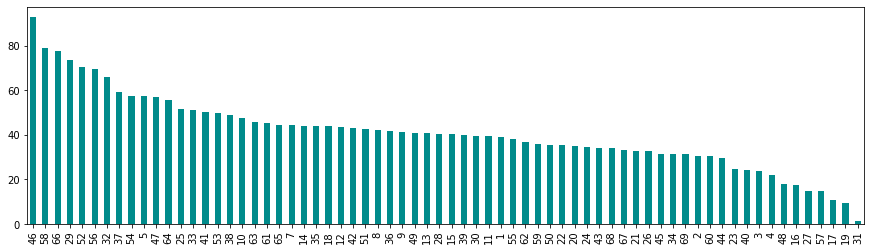

In [100]:
# Average availability of cat1 (Note that; average on percentage is not accurate, this table is just a sample)

# First, we should get rid of % and convert data into numeric value
dfresult2['parts_availablity'] = dfresult2['parts_availablity'].str.rstrip(' " %"').astype(float)

# This code define 'color' locally for the sake of 'print' function
class color:
   GREEN = '\033[92m'
   BOLD = '\033[1m'
   END = '\033[0m'

# Generate some spaces for 'print' function
my_space = ' ' * 25

# This code just automate the procedure so that it'd be easier later to add more cols
col_mean = ['cat1_theme_parent']
for feature in (col_mean):
    dfresult2.groupby(feature)['parts_availablity'].mean().sort_values(ascending=False).plot(kind ='bar', \
                                                                            figsize=(15,4),color='darkcyan', width=0.5)
    plt.title(print('\n',color.BOLD,color.GREEN,my_space,"*** Inventory Availability of",feature,'***',color.END), fontsize=12)
    plt.xlabel('') 
    plt.show();

<a id='1-C'></a>
### <font color=blue><center>1-C: User-defined table</center> ###

In [107]:
# I would like to find the dominating color of minifgs
# dominating color describes as the most repeating color of minifigs' parts as long as they have more than 1 color and 
# there is no two same dominating color.
# Description: 1- Defining a CTE with basic info needed. 2- Find the dominating colors by a self join and MAX occurance
# 3- Save the table as a Temp. 4- Exclude the result of minifigs with two or more dominating colors.
query_q3 = """

BEGIN 
CREATE TEMP TABLE temp_q3 AS
WITH base_table AS (
    SELECT m.name minifig, c.name color, COUNT(c.name) freq
    FROM `clark-643191304.milad_db.minifigs` m
    JOIN `clark-643191304.milad_db.inventories` i ON  m.fig_num = i.set_num AND (i.version = 1)
    JOIN `clark-643191304.milad_db.inventory_parts` ip ON i.id = ip.inventory_id
    JOIN `clark-643191304.milad_db.colors` c ON ip.color_id = c.id
    GROUP BY m.name, c.name
)
SELECT b1.minifig, b1.color dominating_color
FROM base_table b1, (SELECT minifig, MAX(freq) mx_freq FROM base_table GROUP BY minifig HAVING COUNT(minifig)>1) b2
WHERE b1.minifig = b2.minifig AND b1.freq = b2.mx_freq
ORDER BY b1.minifig;
END;

CREATE TABLE `clark-643191304.milad_db.query_q3` AS
SELECT * 
FROM `clark-643191304._scriptb42ca1a7ece4d15f784b3a14ceeb8db52aa5807d.temp_q3`
WHERE minifig NOT IN(
    SELECT minifig 
    FROM `clark-643191304._scriptb42ca1a7ece4d15f784b3a14ceeb8db52aa5807d.temp_q3`
    GROUP BY minifig
    HAVING COUNT(minifig) > 1
);

"""
dfresult3 = pd.read_gbq(query_q3, project_id='clark-643191304', dialect='standard')
dfresult3

Downloading: 100%|█████████████████████████████████████████████████████████████| 6602/6602 [00:01<00:00, 5816.86rows/s]


,minifig,dominating_color
0,Martial Arts Boy (CMF),White
1,"2-1B Medical Droid, Pearl Dark Gray",Dark Bluish Gray
2,"2-1B Medical Droid, Sand Blue Torso, One Arms with Clips at 90°",Light Bluish Gray
3,"2-1B Medical Droid, Tan Torso",Dark Bluish Gray
4,4-LOM,Pearl Dark Gray
...,...,...
6597,Zookeeper,Tan
6598,Zorii Bliss,Dark Red
6599,Zuckuss,Dark Brown
6600,Zugu,Yellow


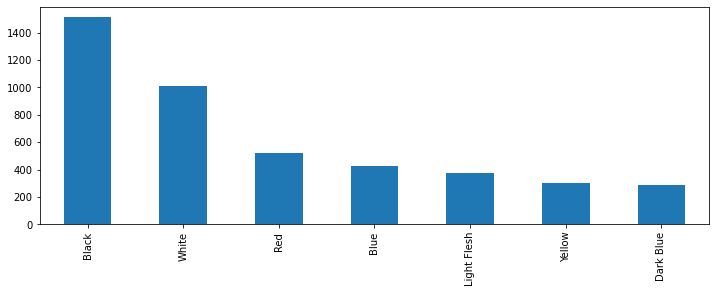

In [114]:
# Most dominating colors (>200) of Lego Sets from the point of view of their parts.

dfresult3['dominating_color'].value_counts().loc[lambda x : x>200].plot(kind='bar', figsize=(12,4), xlim=(0,10));

<a id='2'></a>
### <font color=blue><center>2: ETL Design</center> ###
I designed this Jupyter notebook to bear as much automated characteristic of an standard ETL as possible. But, as broader description and a review, this is how it works for me:<br> 
<br>
**1**- Extracting and gathering data from different sources depending on the project, for example from RDS, Azure, GCP, MySQL, PostgreSQL, MariaDB, Oracle, MongoDB(NoSQL-JSON like), T-SQL, SQLite and etc. And, of course, it can be queried with a handful range of dialects. This stage is called Extract (E). On this stage, we assume that data management, governance, modeling, quality assure and etc. has been performed correctly.<br>
<br>
**2**- The second stage is Transform (T). In this stage, we are supposed to validate the date which consists of profiling, cleansing, exploratory analysis. Many tools provide auto profiling for data analysts for example, SAP, Qlik, and etc. Cleaning also consists of finding anomalies in data, dealing with typos, outliers, duplicates, null values, and etc. And, finally the purpose of exploratory analysis is to find some business insights. Qlik and Power BI both provides business insights as well.<br>
<br>
**3**- The next stage is loading (L). Big data is supposed to be loaded and subsequently passed data warehousing in data warehouses such as Snowflake, BigQuery and Redshift. In this stage, we also need to write and save queries.<br>
<br>
**4**- Then, we need to automate this procedure, it can be done like what I did in Jupyter using Windows Task Scheduler, or task scheduler of BigQuery so that every time we will have the whole procedure done a relatively short time.<br>
<br>
**5**- Finally, we can again load data, or even pass ETL process based on projects, into visualization tools such as Power Bi, Tableau, Qlik Sense, Data Studio and etc. That can be easily done by using connectors. For example, loading from Snowflake to Power Bi, and then simply every time we can just refresh the data and have the new dashboarding. <br> 
<br>
Also, it's worthwhile to again point out and recap what I did in this project:<br> 
AWS RDS (E) **=>>** local hard (it could be S3, GCP, or whatever shared network/ cloud platform) **=>>** Cleaning in Jupyter via Python - fully automated (T) **=>>** loading to BigQuery - saving queries for the future use, data warehousing, answering 3 questions, saving tables automatically  **=>>** Next potential step would be visualization by loading data from BigQuery and refresh it, which I did not have time otherwise I would've given you a glimpse of that as well.



<a id='3'></a>
### <font color=blue><center>3: Question3</center> ###

**-What is database entity?**<br> Any thing like object, item, workflow and etc. which should be captured and stored is entity. The good example of entity management is pgAdmin and Azure Data Studio.
<br>
<br>
**-Three entities and their properties for Grover:**<br> Your business model is rent e-commerce and subscription. So, I'd say Products, Customers, Orders, and Subscription:<br>   
***Products' Properties***: id, category, name, price, description, create_date, thumbnail, delivery, minimum_rental_period.<br>
***Customers' Properties***: id, email, pass, name, country, platform, billing address, shipping address<br>
***Orders' Properties***: order_id, order_dt, fullfilled_dt, sales_channel, total_orders, total_shipping, delivery_time<br>
***Subscriptions' Properties***: customer_id, start/end_dt, plan, is_active_flag, subscription_fee<br>
<br>
**-Relevant KPIs, why important as well as formula:**<br>
By combining and analysing the above tables plus customer service table, marketing campaigns result, Google Analytics output, and tracking events, we would come up with the following KPIs that Grover should monitor:<br>
<br>
1- ***Financial Performance***: Total sales, revenues, profit, Average Order Value (AOV) (sum of value/total orders) and margin value.<br>
2- ***Subscription***: Monthly/Annually Recurring Revenue (MRR) (total monthly/annually revenue from active subscribers), Active Subscriber Counts ASC<br>
3- ***Web Analytics***: session duration (average sessions), bounce rate (users who did not interact with website - i.e session duration less than 30s without any clicks/total), returning user, items reviewed, popular landing or exiting pages, conversion rate, funnel analysis, sessions per user, pageviews per sessions, clickouts per sessions, Click Through Rate (CTR), goals completion, onsite search queries<br>
4- ***Procurement***: compliance rate (number of any differences compared to what agreed/total), supplier defect rate, supplier lead time, vendor availability, number of reviews, score rate, price volatility (standard deviation of price). <br>
5- ***Logistics***: times (process, fulfilment, shipping, delivery, cash-to-cash cycle), order accuracy or perfect order (total orders without any incidents/total), costs (warehousing, packing, transportation, warranty), number of shipments, inventory (accuracy and turnover.) <br>
6- ***Customer service***: CSAT, NPS, CES, review content analysis via NLP, delivery-related KPIs such as returning-product rate and on-time delivery, complaint analysis, first response time vs average resolution time. <br>
7- ***Customer Retention***: (retention rate, churn rate, acquisition rate, existing customers), cohort analysis, repeat purchase ratio and loyal customer rate, product return rate, shopping card abandonment rate. <br>
8- ***Marketing***: users from different source of traffic (AdWords, email, social, organic), cost per impression/acquisition, marketing ROI (usually CLV/cost of marketing), ROAS, CLV (one of the most vital KPIs - all the values customers have contributed during their lifespan OR prediction of that with ML), conversion rate (second most important one - number of checkout/visits), Customer Acquisition Cost (CAC). <br>

    
    
    


    
